In [1]:
import warnings
from typing import List, Dict
from itertools import product

from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

# UTILS

In [2]:
def dict_product(inp):
    return (dict(zip(inp.keys(), values)) for values in product(*inp.values()))

In [12]:
def train_eval_model(model: ClassifierMixin, data: pd.DataFrame, seed: int = 0):
    """Train and evaluate give model on given data"""
    np.random.seed(seed)
    train_data, test_data = train_test_split(data, train_size=0.8, stratify=data["class"])

    X_train, y_train = np.split(train_data, [-1], axis=1)
    X_test, y_test = np.split(test_data, [-1], axis=1)

    scaler = StandardScaler()
    scaler = scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    model.fit(X_train, y_train.squeeze())
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred, zero_division=0))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test.squeeze())
    plt.show()


def grid_search(
    model_class: ClassifierMixin, 
    data: pd.DataFrame, 
    model_params_dict: Dict, 
    cv: int = 5, 
    repeats: int = 5
):
    results = []
    X, y = data.drop("class", axis=1), data["class"]

    model_params_list = list(dict_product(model_params_dict))
    
    with tqdm(total=len(model_params_list)) as pbar:
        pbar.set_description("Grid search")

        for model_params in model_params_list:

            model = model_class(**model_params)
            kfold = RepeatedStratifiedKFold(n_splits=cv, n_repeats=repeats)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                pipeline = make_pipeline(StandardScaler(), model)
                cv_scores = cross_val_score(pipeline, X, np.ravel(y), scoring='f1_weighted', cv=kfold)
            
            result = [
                model_params | {"cv": i, "F1-weighted": cv_score} 
                for i, cv_score in enumerate(cv_scores)
            ] 
            results += result

            pbar.update()

    return pd.DataFrame(results)


def plot_grid_search(
    df: pd.DataFrame, 
    x_key: str, 
    y_key: str, 
    hue_key: str, 
    plot_key: str,
    title: str = None
):

    num_plots = len(df[plot_key].unique())
    main_fig, axes = plt.subplots(1, num_plots, figsize=(20, 16 // num_plots), sharey=True)
    
    if title:
        main_fig.suptitle(title, fontsize=16)

    for i, (ax, (key, plot_df)) in enumerate(zip(axes.flatten(), df.groupby(plot_key))):
        
        sns.boxplot(x=x_key, y=y_key, data=plot_df, hue=hue_key, ax=ax)

        ax.grid(axis='y')
        ax.set_axisbelow(True)
        ax.set_title(f"{plot_key} = {key}")
        
        if i != 0:
            ax.set_ylabel(None)

    plt.tight_layout()
    plt.show()


def plot_model_comparison(
    models: Dict, 
    data: pd.DataFrame, 
    cv: int = 5, 
    repeats: int = 5
):
    
    # Prepare data
    kfold = RepeatedStratifiedKFold(n_splits=cv, n_repeats=repeats)
    X, y = data.drop("class", axis=1), data["class"]
    results = []

    # Run models
    for model_name, model in models.items():
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            pipeline = make_pipeline(StandardScaler(), model)
            cv_scores = cross_val_score(pipeline, X, np.ravel(y), scoring='f1_weighted', cv=kfold)
        
        result = [
            {"model": model_name, "cv": i, "F1-weighted": cv_score} 
            for i, cv_score in enumerate(cv_scores)
        ] 
        results += result

    results = pd.DataFrame(results)
    
    # Plot results
    main_fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    main_fig.suptitle("Comparison of tuned models", fontsize=16)
        
    sns.boxplot(x="model", y="F1-weighted", data=results, ax=ax)
    ax.grid(axis='y')
    ax.set_axisbelow(True)

    plt.tight_layout()
    plt.show()

# IRIS

## 1. Załadowanie zbioru

In [13]:
dir = "zbiory/iris.data"
iris_data = pd.read_csv(dir, names=["sepal-length", "sepal-width", "petal-length", "petal-width", "class"])

iris_data.head()

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## 2. Uruchomienie modeli bazowych

### 2.1 AdaBoost

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.83      1.00      0.91        10
 Iris-virginica       1.00      0.80      0.89        10

       accuracy                           0.93        30
      macro avg       0.94      0.93      0.93        30
   weighted avg       0.94      0.93      0.93        30



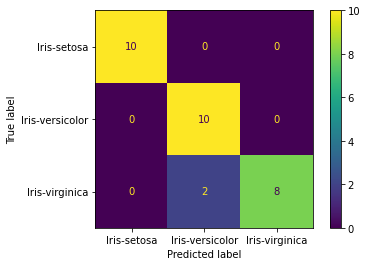

In [5]:
train_eval_model(AdaBoostClassifier(), iris_data)

### 2.2 RandomForestClassifier

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.91      1.00      0.95        10
 Iris-virginica       1.00      0.90      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



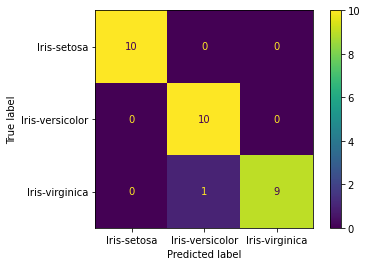

In [6]:
train_eval_model(RandomForestClassifier(), iris_data)

### 2.3 Bagging Classifier

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.83      1.00      0.91        10
 Iris-virginica       1.00      0.80      0.89        10

       accuracy                           0.93        30
      macro avg       0.94      0.93      0.93        30
   weighted avg       0.94      0.93      0.93        30



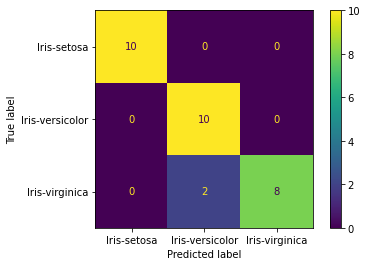

In [14]:
train_eval_model(BaggingClassifier(), iris_data)

## 3. Konfigurowanie modeli

### 3.1 AdaBoost 

Badane parametry:
* *n_estimators* - 
* *learning_rate* -
* *algorithm* -

In [59]:
model_params_list = {
    "n_estimators": [10, 25, 50, 100, 200],
    "learning_rate": [0.25, 0.5, 1.0, 2.0, 4.0],
    "algorithm": ["SAMME", "SAMME.R"]
}

In [61]:
df = grid_search(AdaBoostClassifier, iris_data, model_params_list)

Grid search: 100%|██████████| 50/50 [01:16<00:00,  1.53s/it]


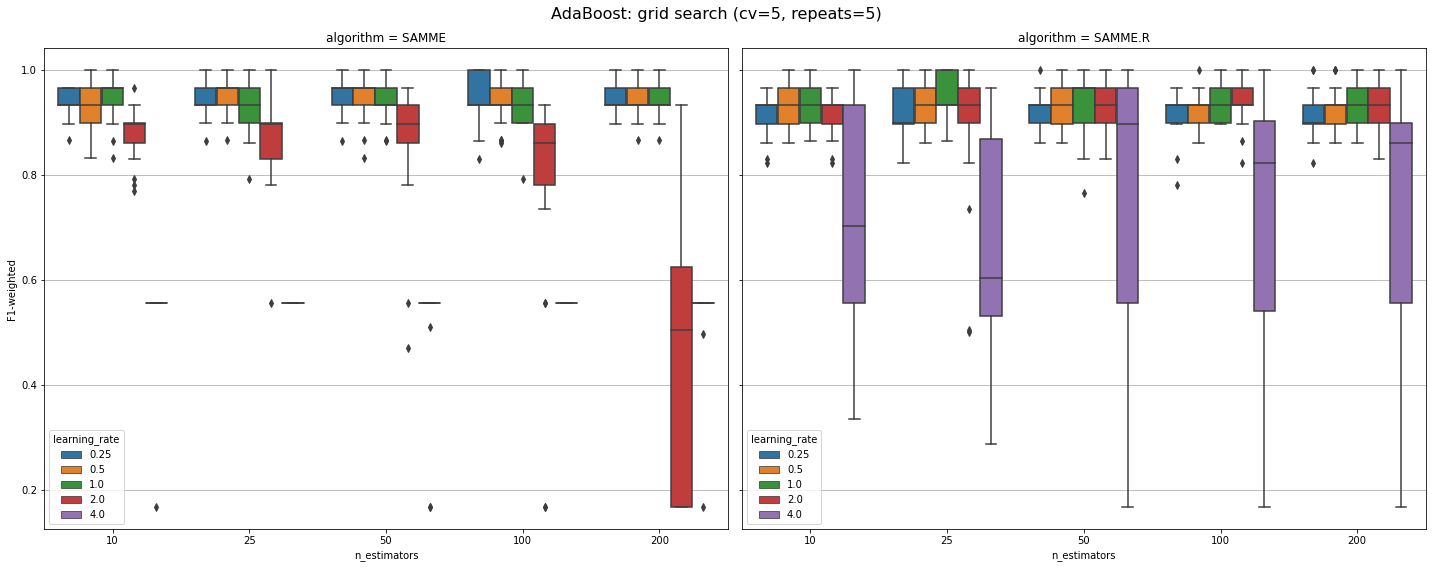

In [77]:
plot_grid_search(
    df, "n_estimators", "F1-weighted", "learning_rate", "algorithm",
    title="AdaBoost: grid search (cv=5, repeats=5)"
)

### 3.2 RandomForestClassifier

Badane parametry:
* *n_estimators* - 
* *max_features* -
*  *min_samples_split* -

In [78]:
model_params_list = {
    "n_estimators": [25, 50, 100, 200, 500],
    "min_samples_split": [2, 3, 5, 10, 20],
    "max_features": [None, "sqrt", "log2"]
}

In [79]:
df = grid_search(RandomForestClassifier, iris_data, model_params_list)

Grid search: 100%|██████████| 75/75 [04:31<00:00,  3.61s/it]


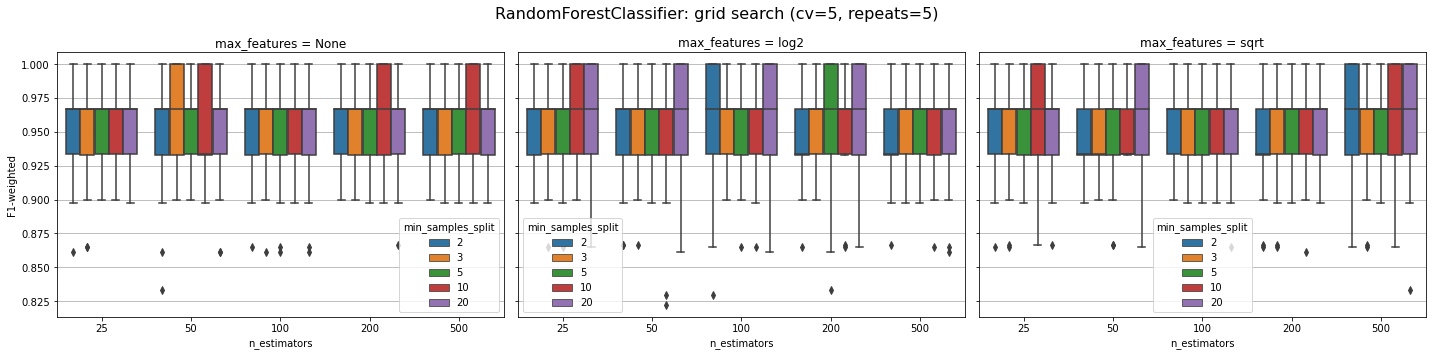

In [102]:
plot_grid_search(
    df.fillna("None"), "n_estimators", "F1-weighted", "min_samples_split", "max_features",
    title="RandomForestClassifier: grid search (cv=5, repeats=5)"
)

### 3.3 BaggingClassifier

Badane parametry: 
* *n_estimators* - 
* *max_features* - 
* *bootstrap* -

In [110]:
model_params_list = {
    "n_estimators": [2, 5, 10, 20, 50],
    "max_features": [0.1, 0.25, 0.5, 0.75, 1.0],
    "bootstrap": [True, False]
}

In [107]:
df = grid_search(BaggingClassifier, iris_data, model_params_list)

Grid search: 100%|██████████| 50/50 [00:24<00:00,  2.05it/s]


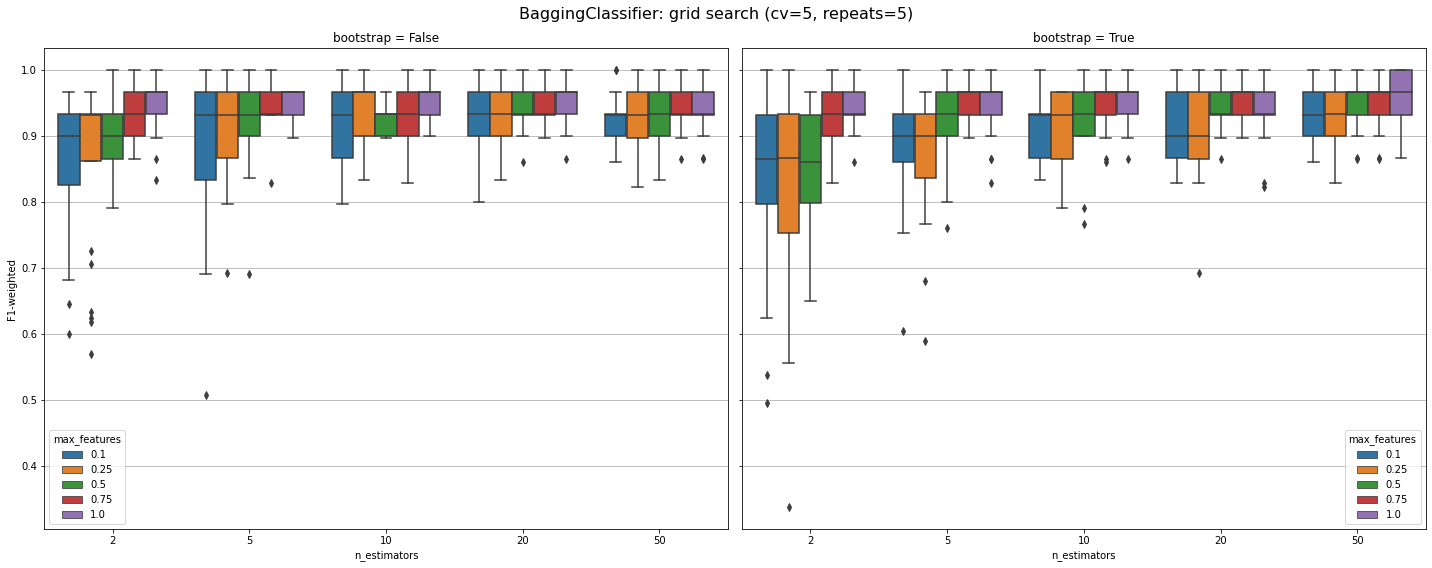

In [108]:
plot_grid_search(
    df, "n_estimators", "F1-weighted", "max_features", "bootstrap",
    title="BaggingClassifier: grid search (cv=5, repeats=5)"
)

## 4. Porównanie najlepszych konfiguracji

In [32]:
models = {
    "AdaBoost": AdaBoostClassifier(n_estimators=25, learning_rate=1.0, algorithm="SAMME.R"),
    "RandomForest": RandomForestClassifier(n_estimators=50, min_samples_split=3, max_features=None),
    "Bagging": BaggingClassifier(n_estimators=50, max_features=1.0, bootstrap=True)
}

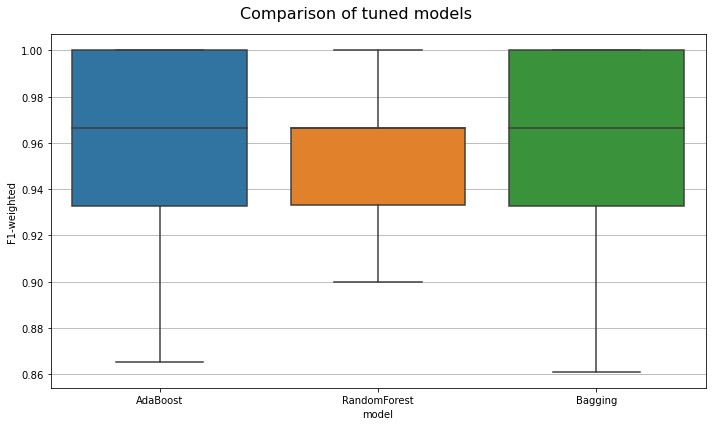

In [33]:
plot_model_comparison(models, iris_data)

# GLASS

## 1. Załadowanie zbioru

In [16]:
dir = "../Lista 0/zbiory/glass.data"
glass_data = pd.read_csv(dir, names=["RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "class"]).reset_index()
glass_data = glass_data.drop("index", axis=1)

glass_data.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,class
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


## 2. Uruchomienie modeli bazowych

### 2.1 AdaBoost

              precision    recall  f1-score   support

         1.0       0.50      0.93      0.65        14
         2.0       0.36      0.27      0.31        15
         3.0       0.00      0.00      0.00         3
         5.0       0.00      0.00      0.00         3
         6.0       1.00      1.00      1.00         2
         7.0       0.75      0.50      0.60         6

    accuracy                           0.51        43
   macro avg       0.44      0.45      0.43        43
weighted avg       0.44      0.51      0.45        43



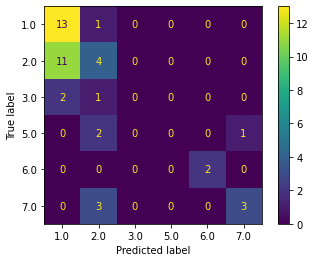

In [17]:
train_eval_model(AdaBoostClassifier(), glass_data)

### 2.2 RandomForest

              precision    recall  f1-score   support

         1.0       0.92      0.86      0.89        14
         2.0       0.88      0.93      0.90        15
         3.0       0.50      0.33      0.40         3
         5.0       0.67      0.67      0.67         3
         6.0       1.00      1.00      1.00         2
         7.0       0.86      1.00      0.92         6

    accuracy                           0.86        43
   macro avg       0.80      0.80      0.80        43
weighted avg       0.85      0.86      0.85        43



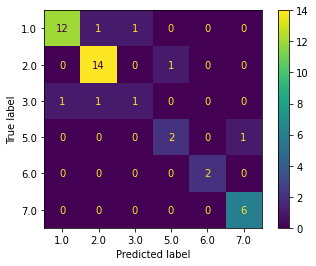

In [18]:
train_eval_model(RandomForestClassifier(), glass_data)

### 2.3 Bagging Classifier

              precision    recall  f1-score   support

         1.0       0.92      0.79      0.85        14
         2.0       0.82      0.93      0.87        15
         3.0       0.50      0.33      0.40         3
         5.0       0.67      0.67      0.67         3
         6.0       1.00      0.50      0.67         2
         7.0       0.75      1.00      0.86         6

    accuracy                           0.81        43
   macro avg       0.78      0.70      0.72        43
weighted avg       0.82      0.81      0.81        43



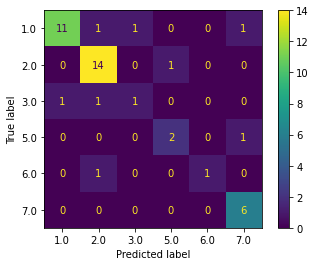

In [19]:
train_eval_model(BaggingClassifier(), glass_data)

## 3. Konfigurowanie modeli

### 3.1 AdaBoost

In [20]:
model_params_list = {
    "n_estimators": [10, 25, 50, 100, 200],
    "learning_rate": [0.25, 0.5, 1.0, 2.0, 4.0],
    "algorithm": ["SAMME", "SAMME.R"]
}

In [21]:
df = grid_search(AdaBoostClassifier, glass_data, model_params_list)

Grid search: 100%|██████████| 50/50 [01:30<00:00,  1.82s/it]


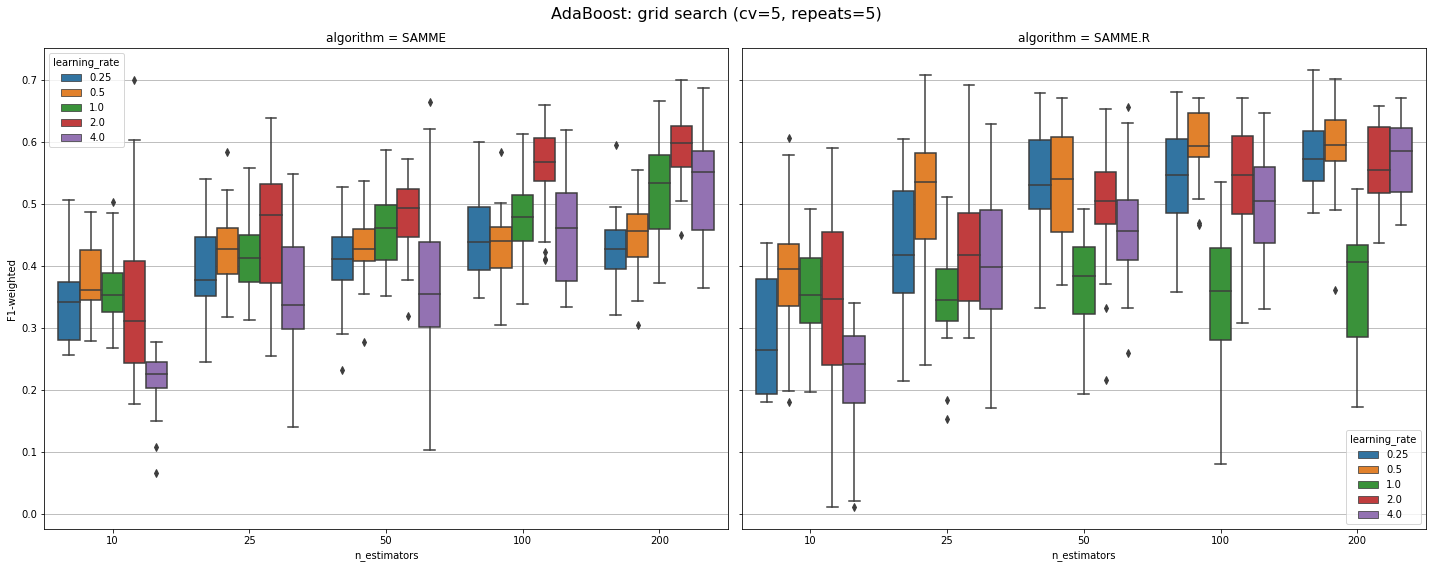

In [23]:
plot_grid_search(
    df, "n_estimators", "F1-weighted", "learning_rate", "algorithm",
    title="AdaBoost: grid search (cv=5, repeats=5)"
)

### 3.2 RandomForest

In [24]:
model_params_list = {
    "n_estimators": [25, 50, 100, 200, 500],
    "min_samples_split": [2, 3, 5, 10, 20],
    "max_features": [None, "sqrt", "log2"]
}

In [25]:
df = grid_search(RandomForestClassifier, glass_data, model_params_list)

Grid search: 100%|██████████| 75/75 [05:13<00:00,  4.18s/it]


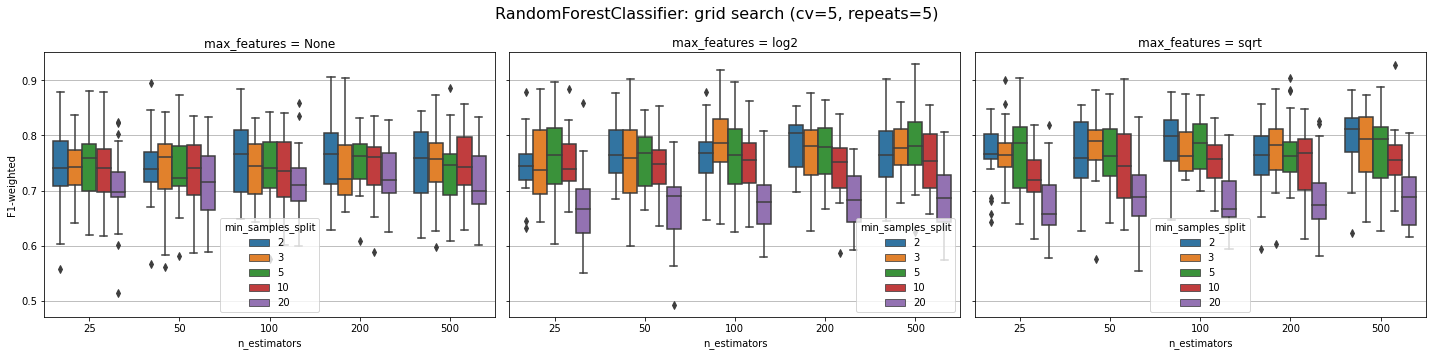

In [26]:
plot_grid_search(
    df.fillna("None"), "n_estimators", "F1-weighted", "min_samples_split", "max_features",
    title="RandomForestClassifier: grid search (cv=5, repeats=5)"
)

### 3.3 BaggingClassifier 

In [27]:
model_params_list = {
    "n_estimators": [2, 5, 10, 20, 50],
    "max_features": [0.1, 0.25, 0.5, 0.75, 1.0],
    "bootstrap": [True, False]
}

In [28]:
df = grid_search(BaggingClassifier, glass_data, model_params_list)

Grid search: 100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


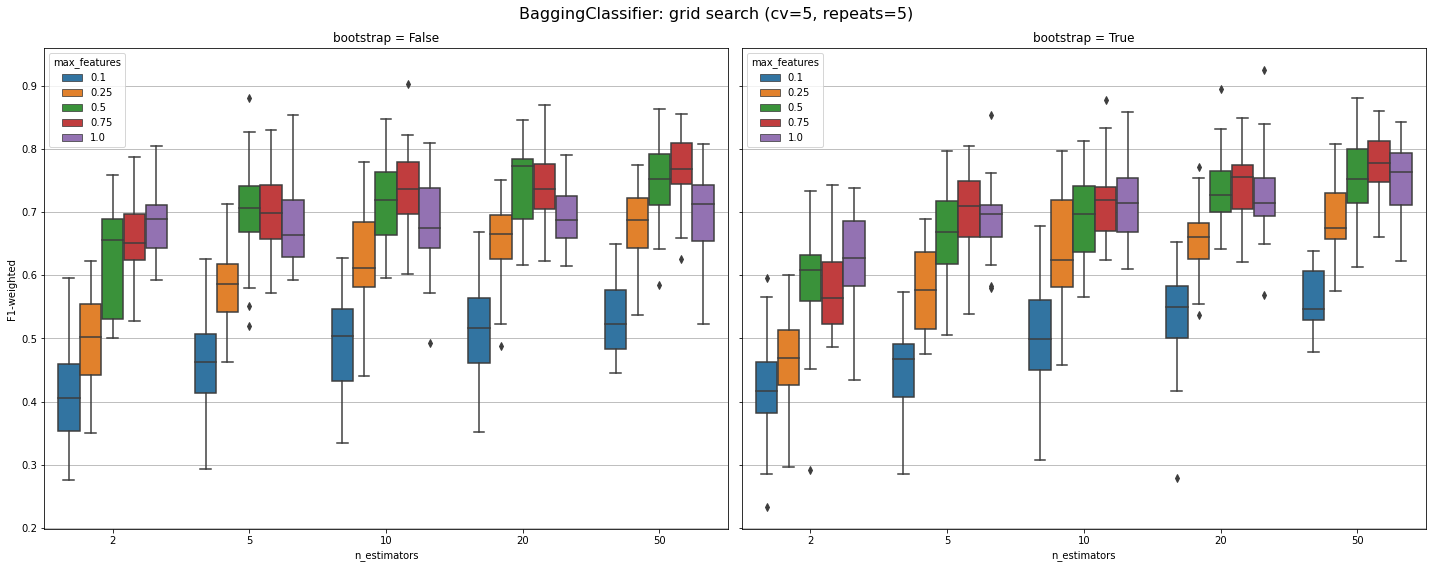

In [29]:
plot_grid_search(
    df, "n_estimators", "F1-weighted", "max_features", "bootstrap",
    title="BaggingClassifier: grid search (cv=5, repeats=5)"
)

## 4. Porównanie najlepszych konfiguracji

In [30]:
models = {
    "AdaBoost": AdaBoostClassifier(n_estimators=100, learning_rate=0.5, algorithm="SAMME.R"),
    "RandomForest": RandomForestClassifier(n_estimators=500, min_samples_split=2, max_features="sqrt"),
    "Bagging": BaggingClassifier(n_estimators=50, max_features=0.75, bootstrap=True)
}

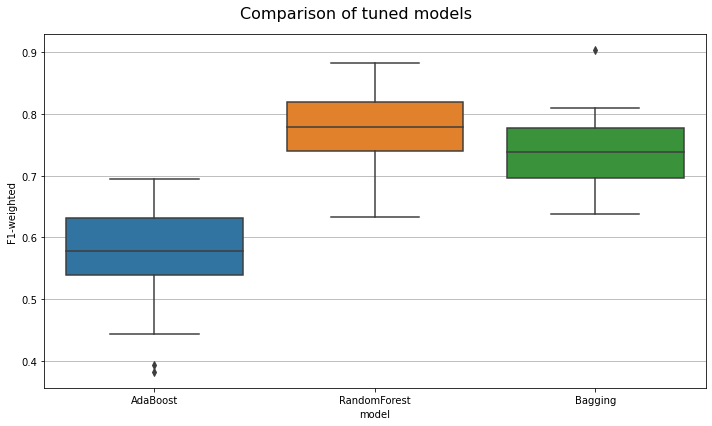

In [31]:
plot_model_comparison(models, glass_data)

# WINE

## 1. Załadowanie zbioru

In [34]:
dir = "../Lista 0/zbiory/wine.data"
wine_data = pd.read_csv(
    dir, 
    names=[
        "class", "Alcohol", "Malic acid", "Ash", "Alcanity of ash", "Magnesium", 
        "Total phenols", "Flavanoids", "Nonflavanoid phenosis", "Proanthocyanins",
        "Color intensity", "Hue", "OD280/OD315 of diluted wine", "Proline"
    ]
)

wine_data = wine_data[list(wine_data.columns.values)[1:] + ["class"]]

wine_data.head()

,Alcohol,Malic acid,Ash,Alcanity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenosis,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wine,Proline,class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


## 2. Uruchomienie modeli bazowych

### 2.1 AdaBoost

              precision    recall  f1-score   support

         1.0       1.00      0.58      0.74        12
         2.0       0.72      0.93      0.81        14
         3.0       0.91      1.00      0.95        10

    accuracy                           0.83        36
   macro avg       0.88      0.84      0.83        36
weighted avg       0.87      0.83      0.83        36



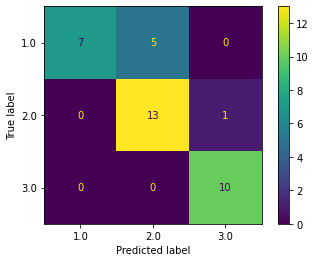

In [36]:
train_eval_model(AdaBoostClassifier(), wine_data)

### 2.2 RandomForest

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12
         2.0       1.00      1.00      1.00        14
         3.0       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



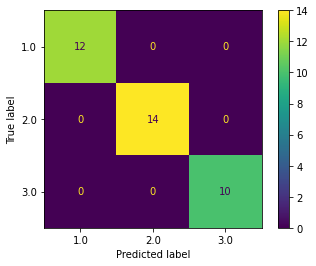

In [37]:
train_eval_model(RandomForestClassifier(), wine_data)

### 2.3 Bagging Classifier

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12
         2.0       0.93      1.00      0.97        14
         3.0       1.00      0.90      0.95        10

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



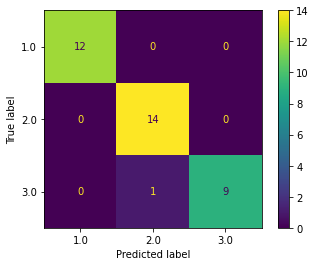

In [38]:
train_eval_model(BaggingClassifier(), wine_data)

## 3. Konfigurowanie modeli

### 3.1 AdaBoost

In [39]:
model_params_list = {
    "n_estimators": [10, 25, 50, 100, 200],
    "learning_rate": [0.25, 0.5, 1.0, 2.0, 4.0],
    "algorithm": ["SAMME", "SAMME.R"]
}

In [40]:
df = grid_search(AdaBoostClassifier, wine_data, model_params_list)

Grid search: 100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


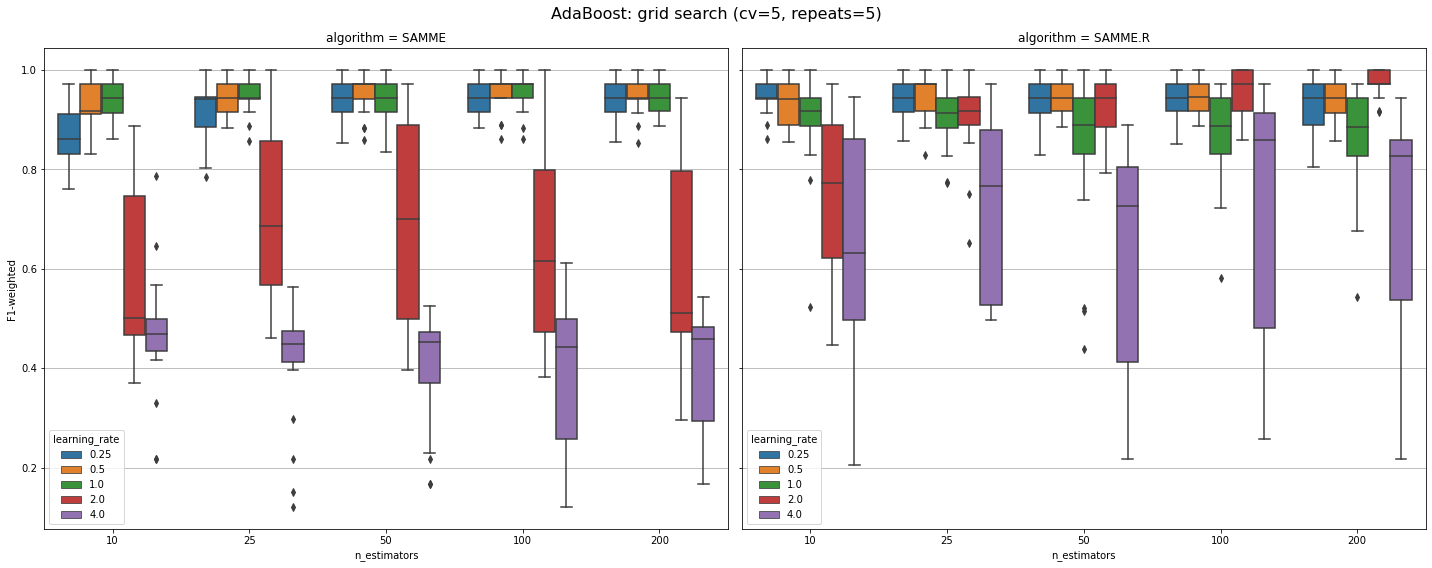

In [41]:
plot_grid_search(
    df, "n_estimators", "F1-weighted", "learning_rate", "algorithm",
    title="AdaBoost: grid search (cv=5, repeats=5)"
)

### 3.2 RandomForest

In [42]:
model_params_list = {
    "n_estimators": [25, 50, 100, 200, 500],
    "min_samples_split": [2, 3, 5, 10, 20],
    "max_features": [None, "sqrt", "log2"]
}

In [43]:
df = grid_search(RandomForestClassifier, wine_data, model_params_list)

Grid search: 100%|██████████| 75/75 [04:51<00:00,  3.89s/it]


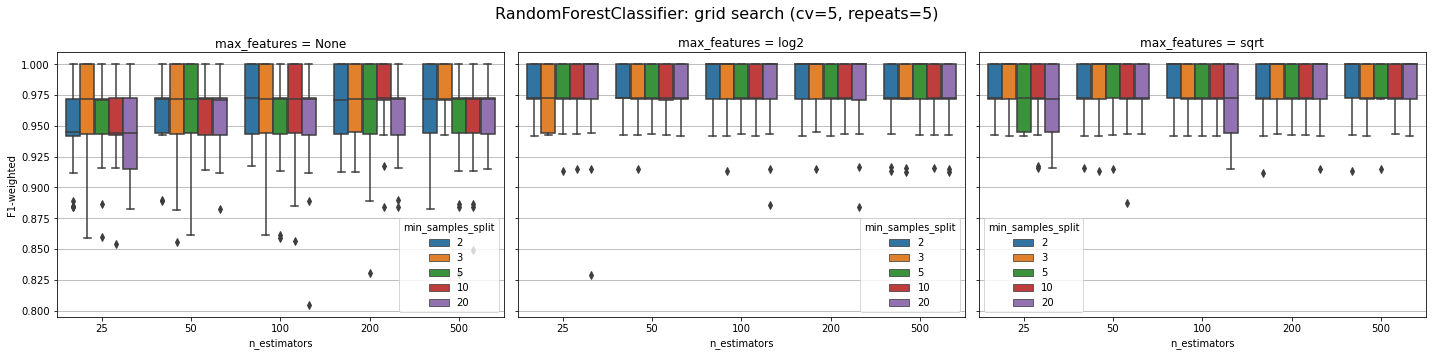

In [44]:
plot_grid_search(
    df.fillna("None"), "n_estimators", "F1-weighted", "min_samples_split", "max_features",
    title="RandomForestClassifier: grid search (cv=5, repeats=5)"
)

### 3.3 BaggingClassifier 

In [45]:
model_params_list = {
    "n_estimators": [2, 5, 10, 20, 50],
    "max_features": [0.1, 0.25, 0.5, 0.75, 1.0],
    "bootstrap": [True, False]
}

In [46]:
df = grid_search(BaggingClassifier, wine_data, model_params_list)

Grid search: 100%|██████████| 50/50 [00:28<00:00,  1.75it/s]


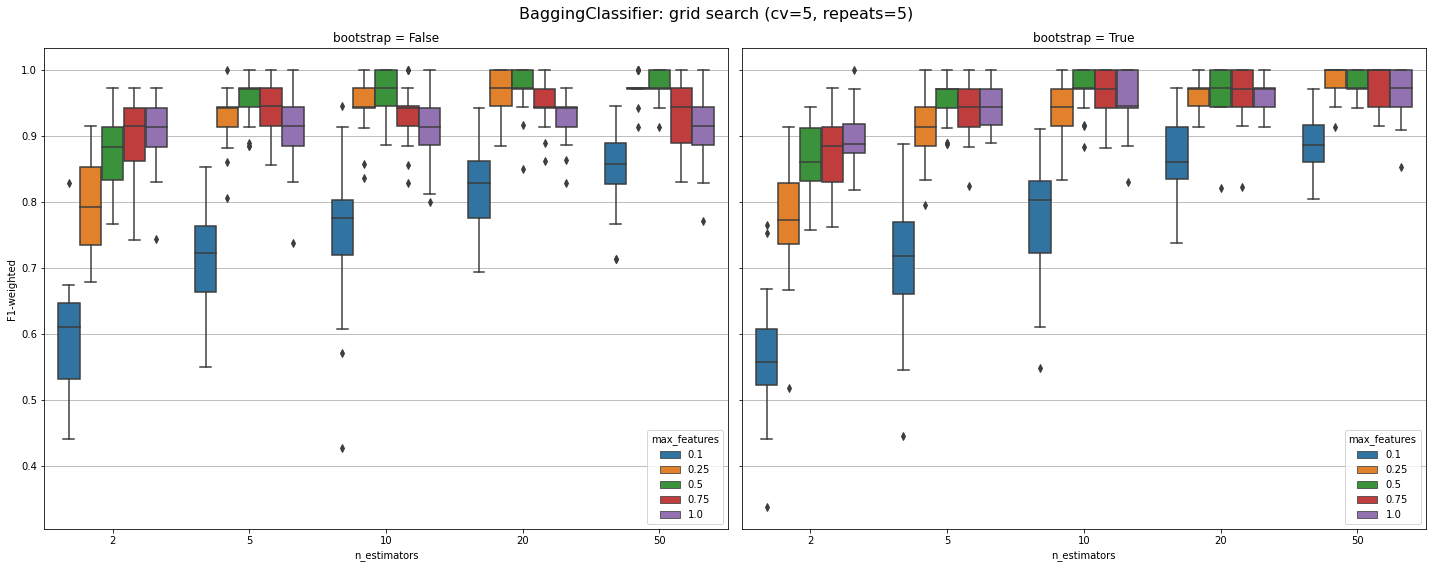

In [47]:
plot_grid_search(
    df, "n_estimators", "F1-weighted", "max_features", "bootstrap",
    title="BaggingClassifier: grid search (cv=5, repeats=5)"
)

## 4. Porównanie najlepszych konfiguracji

In [48]:
models = {
    "AdaBoost": AdaBoostClassifier(n_estimators=200, learning_rate=2, algorithm="SAMME.R"),
    "RandomForest": RandomForestClassifier(n_estimators=500, min_samples_split=3, max_features="log2"),
    "Bagging": BaggingClassifier(n_estimators=50, max_features=0.25, bootstrap=True)
}

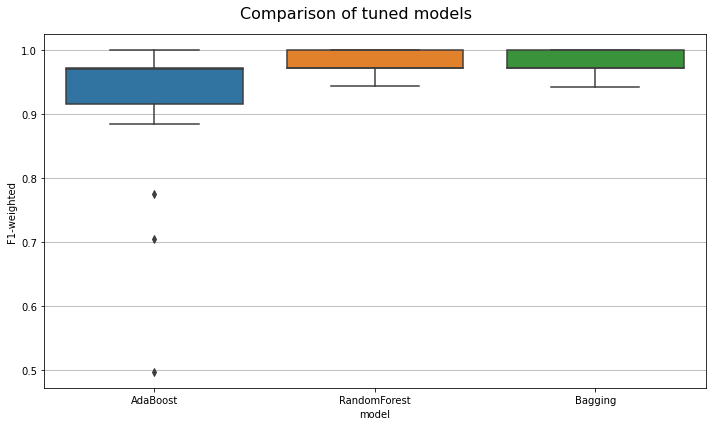

In [49]:
plot_model_comparison(models, wine_data)

# Pytania

### 1. Czy w modelach klasyfikacji podanych w ćwiczeniu potrzebne (wskazane?) jest użycie walidacji krzyżowej?

Odp: 

### 2. Czym różnią się algorytmy badane w zadaniu?

Odp: 

### 3. Który z algorytmów jest łatwiejszy do zrozumienia?

Odp:

### 4. Który z algorytmów łatwiej dostroić?

Odp:

### 5. Który z algorytmów ma najlepszą skuteczność a który z nich ma najlepszą efektywność (zdefiniowaną roboczo jako „czas przetwarzania”)? Kiedy to ma znaczenie?

Odp:

### 6. Z czego składa się finalny model klasyfikacji dla poszczególnych algorytmów?

Odp: